# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

Проведем исследовательский анализ данных:
- Посмотрим на размер выборки.
- Построим график распределения возраста в выборке.
- Напечатаем на экране несколько фотографий и посмотрим, как устроен датасет.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
features, target = next(train_gen_flow)

In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Выведем размер выборки.

In [5]:
labels.shape

(7591, 2)

In [6]:
features.shape

(32, 224, 224, 3)

Выведем график распределения возраста в выборке.

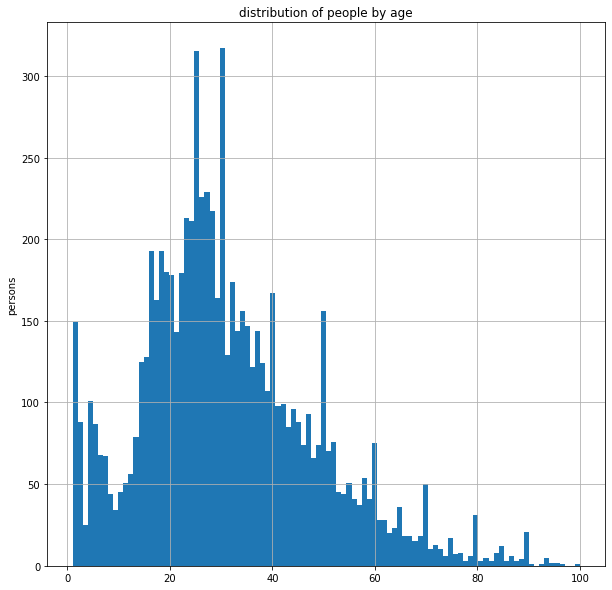

In [7]:
labels.real_age.hist(bins=100, figsize=(10,10))
plt.title('distribution of people by age')
# plt.xlabel('real_age')
plt.ylabel('persons')
plt.show()

Напечатаем на экране несколько фотографий.

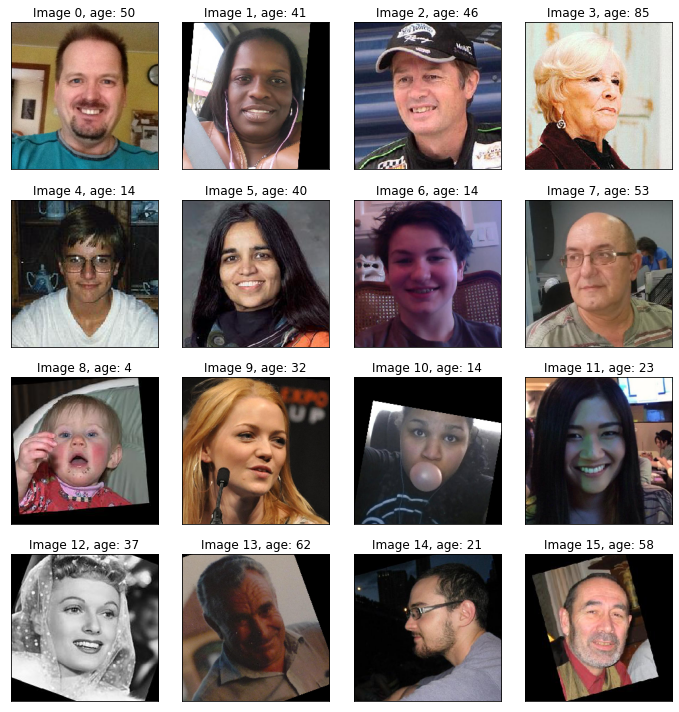

In [8]:
# выводим 16 изображений
fig = plt.figure(figsize=(10,10))

for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.title(f'Image {i}, age: {target[i]}') 
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Выводы

Сделаем выводы о том, как результаты исследования повлияют на обучение модели:
- общее количесво и качество данных позволяет расчитывать на успешное решение поставленной задачи
- имеет смысл использовать предобученную модель ResNet50 и веса 'imagenet'
- в отдельных возрастных категориях недостаточно фотографий
- имеет смысл применить аугментацию
- ориентация фотографий верная (поворачивать их не требуется)
- есть черно-белые фотографии
- различается размер изображений

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# < скопируйте код сюда >

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dense, AvgPool2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,
        horizontal_flip=True
    )
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=(path + 'final_files/'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_datagen_flow


def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25
    )
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=(path + 'final_files/'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
        
    return test_datagen_flow


def create_model(input_shape):
    
    backbone = ResNet50(input_shape=input_shape, 
                        weights='imagenet', 
                        include_top=False)    
      
    model = Sequential()
    
    model.add(backbone) 
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.0001) #lr=0.01 0.001
    
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data, 
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

2022-06-28 09:33:53.038846: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-06-28 09:33:53.040519: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-06-28 09:33:54.988107: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-06-28 09:33:55.665875: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-06-28 09:33:55.665968: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-28 09:33:55.666002: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-28 09:33:55.667851: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-06-28 09:33:55.668232: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-06-28 09:33:55.670414: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-06-28 09:33:55.671574: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-06-28 09:33:55.671643: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-06-28 09:33:55.676052: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-06-28 09:33:55.676411: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-06-28 09:33:55.683521: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2022-06-28 09:33:55.684094: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x43a3670 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-28 09:33:55.684120: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-06-28 09:33:55.828838: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x42e1630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-06-28 09:33:55.828875: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-06-28 09:33:55.831288: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-06-28 09:33:55.831347: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-28 09:33:55.831357: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-28 09:33:55.831387: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-06-28 09:33:55.831397: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-06-28 09:33:55.831406: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-06-28 09:33:55.831415: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-06-28 09:33:55.831422: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-06-28 09:33:55.835816: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-06-28 09:33:55.835876: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-28 09:33:56.146790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-06-28 09:33:56.146843: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-06-28 09:33:56.146851: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-06-28 09:33:56.151518: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-06-28 09:34:10.178493: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-28 09:34:10.545650: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 67s - loss: 236.0436 - mae: 10.9829 - val_loss: 946.1004 - val_mae: 25.9770
Epoch 2/10
2022-06-28 09:33:53.038846: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-06-28 09:33:53.040519: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-06-28 09:33:54.988107: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-06-28 09:33:55.665875: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-06-28 09:33:55.665968: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-28 09:33:55.666002: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-28 09:33:55.667851: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-06-28 09:33:55.668232: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-06-28 09:33:55.670414: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-06-28 09:33:55.671574: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-06-28 09:33:55.671643: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-06-28 09:33:55.676052: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-06-28 09:33:55.676411: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-06-28 09:33:55.683521: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2022-06-28 09:33:55.684094: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x43a3670 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-28 09:33:55.684120: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-06-28 09:33:55.828838: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x42e1630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-06-28 09:33:55.828875: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-06-28 09:33:55.831288: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-06-28 09:33:55.831347: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-28 09:33:55.831357: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-28 09:33:55.831387: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-06-28 09:33:55.831397: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-06-28 09:33:55.831406: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-06-28 09:33:55.831415: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-06-28 09:33:55.831422: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-06-28 09:33:55.835816: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-06-28 09:33:55.835876: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-28 09:33:56.146790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-06-28 09:33:56.146843: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-06-28 09:33:56.146851: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-06-28 09:33:56.151518: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-06-28 09:34:10.178493: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-28 09:34:10.545650: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 67s - loss: 236.0436 - mae: 10.9829 - val_loss: 946.1004 - val_mae: 25.9770
Epoch 2/10
178/178 - 37s - loss: 77.3115 - mae: 6.6121 - val_loss: 905.6088 - val_mae: 25.2322
Epoch 3/10
178/178 - 37s - loss: 50.2127 - mae: 5.3863 - val_loss: 253.9666 - val_mae: 11.8087
Epoch 4/10
178/178 - 37s - loss: 35.5042 - mae: 4.5269 - val_loss: 111.1857 - val_mae: 7.8863
Epoch 5/10
178/178 - 37s - loss: 27.7894 - mae: 3.9756 - val_loss: 91.6945 - val_mae: 7.3925
Epoch 6/10
178/178 - 37s - loss: 22.1092 - mae: 3.5996 - val_loss: 69.0161 - val_mae: 6.2249
Epoch 7/10
178/178 - 37s - loss: 17.7928 - mae: 3.2325 - val_loss: 78.9718 - val_mae: 6.6848
Epoch 8/10
178/178 - 37s - loss: 14.0254 - mae: 2.9058 - val_loss: 63.6949 - val_mae: 6.0935
Epoch 9/10
178/178 - 37s - loss: 11.9594 - mae: 2.6462 - val_loss: 74.2936 - val_mae: 6.3870
Epoch 10/10
178/178 - 36s - loss: 9.9323 - mae: 2.3957 - val_loss: 62.5566 - val_mae: 6.0082
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 62.5566 - mae: 6.0082
Test MAE: 6.0082
2022-06-28 09:33:53.038846: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-06-28 09:33:53.040519: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-06-28 09:33:54.988107: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-06-28 09:33:55.665875: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-06-28 09:33:55.665968: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-28 09:33:55.666002: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-28 09:33:55.667851: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-06-28 09:33:55.668232: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-06-28 09:33:55.670414: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-06-28 09:33:55.671574: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-06-28 09:33:55.671643: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-06-28 09:33:55.676052: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-06-28 09:33:55.676411: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-06-28 09:33:55.683521: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2022-06-28 09:33:55.684094: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x43a3670 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-28 09:33:55.684120: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-06-28 09:33:55.828838: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x42e1630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-06-28 09:33:55.828875: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-06-28 09:33:55.831288: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-06-28 09:33:55.831347: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-28 09:33:55.831357: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-28 09:33:55.831387: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-06-28 09:33:55.831397: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-06-28 09:33:55.831406: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-06-28 09:33:55.831415: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-06-28 09:33:55.831422: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-06-28 09:33:55.835816: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-06-28 09:33:55.835876: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-28 09:33:56.146790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-06-28 09:33:56.146843: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-06-28 09:33:56.146851: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-06-28 09:33:56.151518: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-06-28 09:34:10.178493: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-28 09:34:10.545650: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 67s - loss: 236.0436 - mae: 10.9829 - val_loss: 946.1004 - val_mae: 25.9770
Epoch 2/10
178/178 - 37s - loss: 77.3115 - mae: 6.6121 - val_loss: 905.6088 - val_mae: 25.2322
Epoch 3/10
178/178 - 37s - loss: 50.2127 - mae: 5.3863 - val_loss: 253.9666 - val_mae: 11.8087
Epoch 4/10
178/178 - 37s - loss: 35.5042 - mae: 4.5269 - val_loss: 111.1857 - val_mae: 7.8863
Epoch 5/10
178/178 - 37s - loss: 27.7894 - mae: 3.9756 - val_loss: 91.6945 - val_mae: 7.3925
Epoch 6/10
178/178 - 37s - loss: 22.1092 - mae: 3.5996 - val_loss: 69.0161 - val_mae: 6.2249
Epoch 7/10
178/178 - 37s - loss: 17.7928 - mae: 3.2325 - val_loss: 78.9718 - val_mae: 6.6848
Epoch 8/10
178/178 - 37s - loss: 14.0254 - mae: 2.9058 - val_loss: 63.6949 - val_mae: 6.0935
Epoch 9/10
178/178 - 37s - loss: 11.9594 - mae: 2.6462 - val_loss: 74.2936 - val_mae: 6.3870
Epoch 10/10
178/178 - 36s - loss: 9.9323 - mae: 2.3957 - val_loss: 62.5566 - val_mae: 6.0082
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 62.5566 - mae: 6.0082
Test MAE: 6.0082
2022-06-28 09:33:53.038846: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-06-28 09:33:53.040519: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-06-28 09:33:54.988107: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-06-28 09:33:55.665875: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-06-28 09:33:55.665968: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-28 09:33:55.666002: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-28 09:33:55.667851: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-06-28 09:33:55.668232: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-06-28 09:33:55.670414: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-06-28 09:33:55.671574: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-06-28 09:33:55.671643: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-06-28 09:33:55.676052: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-06-28 09:33:55.676411: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-06-28 09:33:55.683521: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2022-06-28 09:33:55.684094: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x43a3670 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-28 09:33:55.684120: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-06-28 09:33:55.828838: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x42e1630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-06-28 09:33:55.828875: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-06-28 09:33:55.831288: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-06-28 09:33:55.831347: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-28 09:33:55.831357: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-28 09:33:55.831387: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-06-28 09:33:55.831397: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-06-28 09:33:55.831406: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-06-28 09:33:55.831415: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-06-28 09:33:55.831422: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-06-28 09:33:55.835816: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-06-28 09:33:55.835876: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-28 09:33:56.146790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-06-28 09:33:56.146843: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-06-28 09:33:56.146851: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-06-28 09:33:56.151518: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-06-28 09:34:10.178493: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-28 09:34:10.545650: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 67s - loss: 236.0436 - mae: 10.9829 - val_loss: 946.1004 - val_mae: 25.9770
Epoch 2/10
178/178 - 37s - loss: 77.3115 - mae: 6.6121 - val_loss: 905.6088 - val_mae: 25.2322
Epoch 3/10
178/178 - 37s - loss: 50.2127 - mae: 5.3863 - val_loss: 253.9666 - val_mae: 11.8087
Epoch 4/10
178/178 - 37s - loss: 35.5042 - mae: 4.5269 - val_loss: 111.1857 - val_mae: 7.8863
Epoch 5/10
178/178 - 37s - loss: 27.7894 - mae: 3.9756 - val_loss: 91.6945 - val_mae: 7.3925
Epoch 6/10
178/178 - 37s - loss: 22.1092 - mae: 3.5996 - val_loss: 69.0161 - val_mae: 6.2249
Epoch 7/10
178/178 - 37s - loss: 17.7928 - mae: 3.2325 - val_loss: 78.9718 - val_mae: 6.6848
Epoch 8/10
178/178 - 37s - loss: 14.0254 - mae: 2.9058 - val_loss: 63.6949 - val_mae: 6.0935
Epoch 9/10
178/178 - 37s - loss: 11.9594 - mae: 2.6462 - val_loss: 74.2936 - val_mae: 6.3870
Epoch 10/10
178/178 - 36s - loss: 9.9323 - mae: 2.3957 - val_loss: 62.5566 - val_mae: 6.0082
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 62.5566 - mae: 6.0082
Test MAE: 6.0082
2022-06-28 09:33:53.038846: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-06-28 09:33:53.040519: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-06-28 09:33:54.988107: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-06-28 09:33:55.665875: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-06-28 09:33:55.665968: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-28 09:33:55.666002: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-28 09:33:55.667851: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-06-28 09:33:55.668232: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-06-28 09:33:55.670414: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-06-28 09:33:55.671574: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-06-28 09:33:55.671643: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-06-28 09:33:55.676052: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-06-28 09:33:55.676411: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-06-28 09:33:55.683521: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2022-06-28 09:33:55.684094: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x43a3670 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-28 09:33:55.684120: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-06-28 09:33:55.828838: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x42e1630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-06-28 09:33:55.828875: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-06-28 09:33:55.831288: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-06-28 09:33:55.831347: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-28 09:33:55.831357: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-28 09:33:55.831387: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-06-28 09:33:55.831397: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-06-28 09:33:55.831406: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-06-28 09:33:55.831415: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-06-28 09:33:55.831422: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-06-28 09:33:55.835816: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-06-28 09:33:55.835876: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-28 09:33:56.146790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-06-28 09:33:56.146843: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-06-28 09:33:56.146851: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-06-28 09:33:56.151518: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-06-28 09:34:10.178493: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-28 09:34:10.545650: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 67s - loss: 236.0436 - mae: 10.9829 - val_loss: 946.1004 - val_mae: 25.9770
Epoch 2/10
178/178 - 37s - loss: 77.3115 - mae: 6.6121 - val_loss: 905.6088 - val_mae: 25.2322
Epoch 3/10
178/178 - 37s - loss: 50.2127 - mae: 5.3863 - val_loss: 253.9666 - val_mae: 11.8087
Epoch 4/10
178/178 - 37s - loss: 35.5042 - mae: 4.5269 - val_loss: 111.1857 - val_mae: 7.8863
Epoch 5/10
178/178 - 37s - loss: 27.7894 - mae: 3.9756 - val_loss: 91.6945 - val_mae: 7.3925
Epoch 6/10
178/178 - 37s - loss: 22.1092 - mae: 3.5996 - val_loss: 69.0161 - val_mae: 6.2249
Epoch 7/10
178/178 - 37s - loss: 17.7928 - mae: 3.2325 - val_loss: 78.9718 - val_mae: 6.6848
Epoch 8/10
178/178 - 37s - loss: 14.0254 - mae: 2.9058 - val_loss: 63.6949 - val_mae: 6.0935
Epoch 9/10
178/178 - 37s - loss: 11.9594 - mae: 2.6462 - val_loss: 74.2936 - val_mae: 6.3870
Epoch 10/10
178/178 - 36s - loss: 9.9323 - mae: 2.3957 - val_loss: 62.5566 - val_mae: 6.0082
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 62.5566 - mae: 6.0082
Test MAE: 6.0082



```

### Выводы

Модель успешно обучилась, целевая метрика MAE на тестовых данных: 6.0082, что соответствует поставленной задаче.

## Анализ обученной модели

По фотографии нужно определить возраст человека. Это задача регрессии. Число в ответе — это количество лет. Прогноз и верный ответ можно сравнить: чем дальше предсказание от реального ответа, тем оно хуже.

Нужен всего один нейрон, который вернёт число-предсказание. 

Для него выберем активацию ReLU. Положительные прогнозы сети функция ReLU не меняет, а все отрицательные — приводит к нулю. Чисел меньше 0 быть не может.

Поскольку решаем задачу регрессии, в качестве функции потерь используем Mean Squared Error (оптимальнее для вычислений), а качестве метрики - Mean Absolute Error (интуитивно понятнее для восприятия человеком).

Использование предобученной модели ResNet50 и весов 'imagenet', позволило сократить время обучения и повысить точность предсказания.

Значение целевой метрики MAE на тестовых данных: 6.0082, что соответствует поставленной задаче.

### Выводы

Построена модель, которая по фотографии определяет приблизительный возраст человека.

Сетевой супермаркет «Хлеб-Соль» может использовать данную модель в системе компьютерного зрения для обработки фотографий покупателей, чтобы анализировать покупки и предлагать товары, которые могут заинтересовать покупателей определенной возрастной группы. 

Для решения второй задачи - контроля добросовестности кассиров при продаже алкоголя, использование данной модели не очевидно, полскольку метрика MAE 6.0082, дает слишком большое отклонение. Для решения этой задачи рекомендуется продолжить исследования и рассмотреть возможность создания специализированной модели.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы